In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import tensorflow as tf
old_v = tf.compat.v1.logging.get_verbosity()
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import h5py
from scipy.io import loadmat

import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, losses, metrics, models, optimizers

abspath = os.getcwd()
datapath = os.path.join(abspath, "dataset")
parampath = os.path.join(abspath, "param")

def get_session(memory_limit=8192):
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            tf.config.experimental.set_virtual_device_configuration(
                gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory_limit)])
        except RuntimeError as e:
            print(e)

def normalize(x):
    return (x-127.5)/127.5
    
def recover(x):
    return ((x+127.5)*127.5).astype(np.uint8)

def load_data(mat_file):
    """
    Helper function for loading a MAT-File
    """
    
    global datapath
    
    src = os.path.join(datapath, mat_file)
    data = loadmat(src)
    
    return data['X'], data['y']

    
class Dataset:

    def getTask(self):
        return type(self).__name__, self.x, self.y

    def showSamples(self, nrows, ncols):
        """
        Plot nrows x ncols images
        """
        fig, axes = plt.subplots(nrows, ncols)
        
        for i, ax in enumerate(axes.flat):
            img = recover(self.x[i,:])
            ax.imshow(img)
            ax.set_xticks([]); ax.set_yticks([])
            ax.set_title(np.argmax(self.y[i]))
        
        plt.show()

        
class MNISTdata(Dataset):
    """
    MNIST dataset
    
    A large collection of monochrome images of handwritten digits
    
    It has a training set of 55,000 examples, and a test set of 10,000 examples
    """

    def __init__(self):
        (x_train, y_train), (x_val, y_val) = datasets.mnist.load_data()
        x_train = normalize(np.reshape(x_train[5000:], [-1, 28, 28, 1]))
        x_val = normalize(np.reshape(x_val, [-1, 28, 28, 1]))
        x_train = np.concatenate([x_train, x_train, x_train], 3)
        x_val = np.concatenate([x_val, x_val, x_val], 3)
        
        print("MNIST : Training Set", x_train.shape)
        print("MNIST : Test Set", x_val.shape)
        
        # Calculate the total number of images
        num_images = x_train.shape[0] + x_val.shape[0]
        print("MNIST : Total Number of Images", num_images)
        
        y_train = np.eye(10)[y_train[5000:]]
        y_val = np.eye(10)[y_val]
        
        self.x = np.vstack([x_train, x_val])
        self.y = np.vstack([y_train, y_val])


class USPSdata(Dataset):
    """
    USPS dataset
    
    A digit dataset automatically scanned from envelopes by the U.S. Postal Service.
    
    It contains a total of 9,298 16×16 pixel grayscale samples
    """

    def __init__(self):
        global datapath
        
        src = os.path.join(datapath, "usps.h5")
        
        with h5py.File(src, 'r') as hf:
            train = hf.get('train')
            test = hf.get('test')
            x_train = np.reshape(train.get('data')[:], [-1, 16, 16, 1])
            x_val = np.reshape(test.get('data')[:], [-1, 16, 16, 1])

            # Magnify the original images
            x_train = tf.image.resize(x_train, [28, 28])
            x_val = tf.image.resize(x_val, [28, 28])
            x_train = np.concatenate([x_train, x_train, x_train], 3)
            x_val = np.concatenate([x_val, x_val, x_val], 3)

            y_train = np.eye(10)[train.get('target')[:]]
            y_val = np.eye(10)[test.get('target')[:]]
        
            print("USPS : Training Set", x_train.shape)
            print("USPS : Test Set", x_val.shape)
        
            # Calculate the total number of images
            num_images = x_train.shape[0] + x_val.shape[0]
            print("USPS : Total Number of Images", num_images)
        
            self.x = 2*(np.vstack([x_train, x_val])-0.5)
            self.y = np.vstack([y_train, y_val])

            
class SVHNdata(Dataset):
    """
    A digit classification benchmark dataset that contains the street view house number (SVHN) images
    
    This dataset includes 99,289 32×32 RGB images of printed digits cropped from pictures of house number plates.
    """

    def __init__(self):
        x_train, y_train = load_data("train_32x32.mat")
        x_val, y_val = load_data("test_32x32.mat")

        x_train, y_train = x_train.transpose((3,0,1,2)), y_train[:,0]
        x_val, y_val = x_val.transpose((3,0,1,2)), y_val[:,0]

        y_train[y_train == 10] = 0
        y_val[y_val == 10] = 0
        
        # Fit the OneHotEncoder
        enc = OneHotEncoder().fit(y_train.reshape(-1, 1))
        
        # Transform the label values to a one-hot-encoding scheme
        y_train = enc.transform(y_train.reshape(-1, 1)).toarray()
        y_val = enc.transform(y_val.reshape(-1, 1)).toarray()
        
        x_train = tf.image.resize(x_train, [28, 28])
        x_val = tf.image.resize(x_val, [28, 28])
        
        print("SVHN : Training Set", x_train.shape)
        print("SVHN : Test Set", x_val.shape)
        
        # Calculate the total number of images
        num_images = x_train.shape[0] + x_val.shape[0]
        print("SVHN : Total Number of Images", num_images)
        
        self.x = normalize(np.vstack([x_train, x_val]))
        self.y = np.vstack([y_train, y_val])
        
        
class Model:
    
    def __init__(self, classes=10):
        self.cce = losses.CategoricalCrossentropy(from_logits=True)
        self.acc = metrics.CategoricalAccuracy()
        
    def sampling(self, ds, expected_size, buffer_size=2048):
        ds_size = ds.cardinality().numpy()
        
        if ds_size < expected_size:
            ds = ds.repeat(expected_size//ds_size + 1)
            
        ds = ds.shuffle(buffer_size=buffer_size).take(expected_size)
        
        return ds
        
    def create_ds(self, x, y, batch_size=200, train_size=20000, val_size=2000):
        x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, shuffle=True)
        
        # Prepare the training dataset.
        train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
        train_ds = self.sampling(train_ds, train_size).batch(batch_size)

        # Prepare the validation dataset.
        val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
        val_ds = self.sampling(val_ds, val_size).batch(batch_size)
        
        return train_ds, val_ds
    
    def loss_sol(self, y_true, y_hat):
        loss_true = self.cce(y_true, y_hat)
        
        return loss_true
    
    def build_solver(self, img_height=28, img_width=28, classes=10, name="Naive NN"):
        self.sol = models.Sequential([
            layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(2, 2), padding='same', input_shape=(img_height, img_width, 3)),
            layers.LeakyReLU(alpha=0.3),
            layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(2, 2), padding='same'),
            layers.LeakyReLU(alpha=0.3),
            layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(2, 2), padding='same'),
            layers.LeakyReLU(alpha=0.3),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dense(classes)
        ], name=name)
        
        self.opt_sol = optimizers.Adam(learning_rate=0.001)
        
    def step_solver(self, x, y, trainable=True):
        
        with tf.GradientTape() as t_sol:

            y_hat = self.sol(x, training=trainable)
            
            ls = self.loss_sol(y, y_hat)
            self.acc.reset_states()
            self.acc.update_state(y, y_hat)
            acc = self.acc.result().numpy()
            
            if trainable :
                grad_sol = t_sol.gradient(ls, self.sol.trainable_variables)
                self.opt_sol.apply_gradients(zip(grad_sol, self.sol.trainable_variables))
            
            return ls, acc
        
    def train_solver(self, data, ckpt_name, prev_scholars=None, epochs=5, verbose=1):
        global parampath
        
        if not hasattr(self, 'task'):
            print("┕Prepare data input pipeline...")
            self.prepare_batch(data, prev_scholars)
        
        task_name, train_ds, val_ds = self.task
        
        if verbose == 2 :
            self.sol.summary()
            print()
            
        train_steps = train_ds.cardinality().numpy()
        val_steps = val_ds.cardinality().numpy()
        
        if prev_scholars != None :
            for sch in prev_scholars:
                prev_task, _, _ = sch.task
                self.history['loss_'+prev_task] = []
                self.history['accuracy_'+prev_task] = []
                
        self.history['loss_'+task_name] = []
        self.history['accuracy_'+task_name] = []
            
        for epoch in range(epochs):
            
            # Iterate over the batches of the dataset.
            for step, (batch_x, batch_y) in enumerate(train_ds):
                ls, acc = self.step_solver(batch_x, batch_y)
                
                msg_prefix = '▶%s Ep.%2d'%(self.sol.name, epoch + 1)
                msg_suffix = 'Train [loss :%.3f accuracy:%.3f]'%(ls, acc)
                
                self.print_progress(msg_prefix, msg_suffix, step, train_steps)
                
                if (step+1)%5 == 0 :
                    val_loss = 0.
                    val_acc = 0.
            
                    # Iterate over the batches of the dataset.
                    for _, (batch_vx, batch_vy) in enumerate(val_ds):
                        vls, vacc = self.step_solver(batch_vx, batch_vy, trainable=False)
                        val_loss += vls.numpy()/val_steps
                        val_acc += vacc/val_steps
                
                    self.history['loss_'+task_name].append(val_loss)
                    self.history['accuracy_'+task_name].append(val_acc)
            
                    if step + 1 == train_steps :
                        print('  Test [loss:%.3f accuracy:%.3f]'%(val_loss, val_acc), end='')
            
                    if prev_scholars != None :
                    
                        for sch in prev_scholars:
                            prev_task, _, prev_val_ds = sch.task
                            prev_val_loss = 0.
                            prev_val_acc = 0.
                
                            prev_val_steps = prev_val_ds.cardinality().numpy()
            
                            # Iterate over the batches of the dataset.
                            for _, (batch_pvx, batch_pvy) in enumerate(prev_val_ds):
                                pvls, pvacc = self.step_solver(batch_pvx, batch_pvy, trainable=False)
                                prev_val_loss += pvls.numpy()/prev_val_steps
                                prev_val_acc += pvacc/prev_val_steps
                        
                            self.history['loss_'+prev_task].append(prev_val_loss)
                            self.history['accuracy_'+prev_task].append(prev_val_acc)
                    
                            if step + 1 == train_steps :
                                print('  %s [loss:%.3f accuracy:%.3f]'%(prev_task, prev_val_loss, prev_val_acc), end='')
                    
            print()
            
        ckpt = os.path.join(parampath, ckpt_name, 'sol_'+task_name+'.h5')
        self.sol.save(ckpt)
        
        return self.history
    
    def print_progress(self, msg_prefix, msg_suffix, step, tot_steps, bar_len=36):
        filled_len = int(round(bar_len * (step+1) / float(tot_steps)))
        bar = '#' * filled_len + '-' * (bar_len - filled_len)
        print('\r%s [%s] %s'%(msg_prefix, bar, msg_suffix), end='')
    
        
class NaiveNN(Model):
    """
    A typical neural network architecture
    """
    
    def __init__(self, classes=10):
        self.build_solver(classes=classes)
        super().__init__()
        
    def prepare_batch(self, data, prev_scholars=None, batch_size=200):
        task_name, x, y = data.getTask()
        self.history = {}
        
        train_ds, val_ds = self.create_ds(x, y, batch_size=batch_size)
        self.task = (task_name, train_ds, val_ds)
    

class Scholar(Model):
    """
    A Generator-Solver pair that produces fake data and desired target pairs.
    """

    def __init__(self, classes=10):
        self.build_generator(classes=classes)
        self.build_solver(classes=classes, name="Solver")
        self.ce = losses.BinaryCrossentropy(from_logits=True)
        self.gen_acc = metrics.BinaryAccuracy()
        super().__init__()
        
    def copy(self, prev_scholar):
        self.sol = models.clone_model(prev_scholar.sol)
        self.sol.set_weights(prev_scholar.sol.get_weights())
        self.gen = models.clone_model(prev_scholar.gen)
        self.gen.set_weights(prev_scholar.gen.get_weights())
        self.disc = models.clone_model(prev_scholar.disc)
        self.disc.set_weights(prev_scholar.disc.get_weights())
        
    def loss_disc(self, y_hat_real, y_hat_fake):
        loss_real = self.ce(tf.ones_like(y_hat_real), y_hat_real)
        loss_fake = self.ce(tf.zeros_like(y_hat_fake), y_hat_fake)
        
        return loss_real + loss_fake
    
    def loss_gen(self, y_hat_fake):
        loss_fake = self.ce(tf.ones_like(y_hat_fake), y_hat_fake)
        
        return loss_fake
        
    def step_generator(self, x_real, noise_size=100):
        batch_size=tf.shape(x_real).numpy()[0]
        noise = tf.random.normal([batch_size, noise_size])
        
        with tf.GradientTape() as t_gen, tf.GradientTape() as t_disc:
            x_fake = self.gen(noise, training=True)

            y_hat_real = self.disc(x_real, training=True)
            y_hat_fake = self.disc(x_fake, training=True)
            
            y_hat = tf.stack([y_hat_real, y_hat_fake])
            y = tf.stack([tf.zeros_like(y_hat_real), tf.ones_like(y_hat_fake)])

            ld, lg = self.loss_disc(y_hat_real, y_hat_fake), self.loss_gen(y_hat_fake)
            
            self.gen_acc.reset_states()
            self.gen_acc.update_state(y, y_hat)
            gacc = self.gen_acc.result().numpy()
            
            grad_gen = t_gen.gradient(lg, self.gen.trainable_variables)
            grad_disc = t_disc.gradient(ld, self.disc.trainable_variables)

            self.opt_gen.apply_gradients(zip(grad_gen, self.gen.trainable_variables))
            self.opt_disc.apply_gradients(zip(grad_disc, self.disc.trainable_variables))
            
            return ld, lg, gacc
        
    def build_generator(self, img_height=28, img_width=28, noise_size=100, classes=10):
        self.gen = models.Sequential([
            layers.Dense(7*7*64, use_bias=False, input_shape=(noise_size,)),
            layers.LeakyReLU(alpha=0.3),
            layers.Reshape((7, 7, 64)),
            layers.Conv2DTranspose(filters=64, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False),
            layers.LeakyReLU(alpha=0.3),
            layers.Conv2DTranspose(filters=64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False),
            layers.LeakyReLU(alpha=0.3),
            layers.Conv2DTranspose(filters=3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
        ], name="Generator")
        
        assert self.gen.output_shape == (None, img_height, img_width, 3)
        
        self.opt_gen = optimizers.Adam(learning_rate=0.0001)
        
        self.disc = models.Sequential([
            layers.Conv2D(filters=64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(img_height, img_width, 3)),
            layers.LeakyReLU(alpha=0.3),
            layers.Dropout(0.3),
            layers.Conv2D(filters=64, kernel_size=(5, 5), strides=(2, 2), padding='same'),
            layers.LeakyReLU(alpha=0.3),
            layers.Dropout(0.3),
            layers.Flatten(),
            layers.Dense(1)
        ], name="Discriminator")
        
        self.opt_disc = optimizers.Adam(learning_rate=0.0001)
        
    def prepare_batch(self, data, prev_scholars=None, batch_size=200, noise_size=100, prop=0.9):
        task_name, x, y = data.getTask()
        self.history = {}
        
        if prev_scholars != None :
            self.copy(prev_scholars[-1])
            
            true_samples = y.shape[0]
            fake_samples = int((1-prop)/prop*true_samples)
            
            for i in range(0, fake_samples, batch_size):
                noise = tf.random.normal([min(batch_size, fake_samples-i), noise_size])
                x_fake = self.gen(noise, training=False)
                y_fake = self.sol(x_fake, training=False).numpy()
                y_fake = (y_fake == y_fake.max(axis=1)[:,None]).astype(int)
                
                x = np.vstack([x, x_fake])
                y = np.vstack([y, y_fake])
                
        train_ds, val_ds = self.create_ds(x, y, batch_size=batch_size)
        
        self.task = (task_name, train_ds, val_ds)
        
    def train_generator(self, data, ckpt_name, epochs=50, verbose=1):
        global parampath
        
        if not hasattr(self, 'task'):
            self.prepare_batch(data)
        
        task_name, train_ds, val_ds = self.task
        
        if verbose == 2 :
            self.gen.summary()
            print()
            self.disc.summary()
            print()
            
        train_steps = train_ds.cardinality().numpy()
            
        for epoch in range(epochs):
            
            # Iterate over the batches of the dataset.
            for step, (batch_x, batch_y) in enumerate(train_ds):
                lg, ld, gacc = self.step_generator(batch_x)
                
                msg_prefix = '▶Generator  Ep.%2d'%(epoch + 1)
                msg_suffix = 'Generator [loss:%.3f]  Discriminator [loss:%.3f accuracy:%.3f]'%(lg, ld, gacc)
                
                self.print_progress(msg_prefix, msg_suffix, step, train_steps)
                
            print()
            
        for nn, name in zip([self.gen, self.disc], ['gen', 'disc']):
            ckpt = os.path.join(parampath, ckpt_name, name+'_'+task_name+'.h5')
            nn.save(ckpt)
    
    def generate_images(self, nrows=2, ncols=8, num_samples = 100, noise_size=100):
        noise = tf.random.normal([num_samples, noise_size])
        samples = self.gen(noise, training=False).numpy()
        
        fig, axes = plt.subplots(nrows, ncols)
        
        for i, ax in enumerate(axes.flat): 
            img = recover(samples[i,:])
            ax.imshow(img)
            ax.axis('off')
        
        plt.show()      
    
    
def visualize_acc(histories, maxiter=50):
    """
    Plot accuracy
    """
    
    num_task = len(histories)
    
    fig, axs = plt.subplots(1, num_task, figsize=(12, 4))
    plt.rc('font',family='DejaVu Sans', size=14)
    
    axs[0].set_ylabel("Accuracy", fontsize=18)
    
    for i in range(num_task) :
        for metric, result in histories[i].items():
            
            if metric[:8] != 'accuracy':
                continue
                
            task_name = metric[9:].replace('data', '')
                
            axs[i].plot(list(range(0, maxiter+1)), 
                           [histories[i-1][metric][maxiter] if i > 0 and metric in histories[i-1] else 0.0]+result[:maxiter], 
                           label=task_name, linewidth=3, clip_on=False)
            
            axs[i].set_xlim([0, maxiter])
            axs[i].set_ylim([0.0, 1.0])
            axs[i].set_xticklabels(list(range(0, maxiter+1, maxiter//5)), fontsize=14)
            axs[i].set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=14)
            axs[i].set_xticks(range(0, maxiter+1, maxiter//10), minor=True)
            axs[i].set_yticks([i/10 for i in range(0, 11)], minor=True)
            axs[i].set_xlabel("Iterations", fontsize=18) 
            axs[i].legend(markerscale=1, fontsize=14, loc='lower right')
            axs[i].grid(which='both', color='#BDBDBD', linestyle='--', linewidth=1)
    
    fig.tight_layout()
    plt.show()
    
get_session()

## hello

MNIST : Training Set (55000, 28, 28, 3)
MNIST : Test Set (10000, 28, 28, 3)
MNIST : Total Number of Images 65000


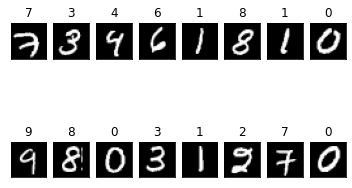

In [2]:
mnist = MNISTdata()
mnist.showSamples(2, 8)

## hello

In [3]:
M = NaiveNN()
hn_mnist = M.train_solver(data=mnist, ckpt_name='NaiveNN', verbose=2)

┕Prepare data input pipeline...
Model: "Naive NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)         

## hello

In [4]:
S1 = Scholar()
hs_mnist = S1.train_solver(data=mnist, ckpt_name='scholar1', verbose=2)

┕Prepare data input pipeline...
Model: "Solver"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 14, 14, 32)        896       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)         

## hello

In [5]:
S1.train_generator(data=mnist, ckpt_name='scholar1', verbose=2)

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 3136)              313600    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 3136)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 64)          102400    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        102400    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 64)        0 

▶Generator  Ep.44 [####################################] Generator [loss:0.794]  Discriminator [loss:1.615 accuracy:0.157]
▶Generator  Ep.45 [####################################] Generator [loss:0.729]  Discriminator [loss:1.691 accuracy:0.153]
▶Generator  Ep.46 [####################################] Generator [loss:0.808]  Discriminator [loss:1.675 accuracy:0.188]
▶Generator  Ep.47 [####################################] Generator [loss:0.867]  Discriminator [loss:1.403 accuracy:0.183]
▶Generator  Ep.48 [####################################] Generator [loss:0.671]  Discriminator [loss:2.007 accuracy:0.165]
▶Generator  Ep.49 [####################################] Generator [loss:1.190]  Discriminator [loss:1.366 accuracy:0.310]
▶Generator  Ep.50 [####################################] Generator [loss:1.237]  Discriminator [loss:1.399 accuracy:0.308]


## hello

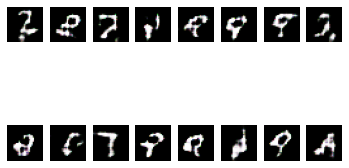

In [6]:
S1.generate_images()

## hello

USPS : Training Set (7291, 28, 28, 3)
USPS : Test Set (2007, 28, 28, 3)
USPS : Total Number of Images 9298


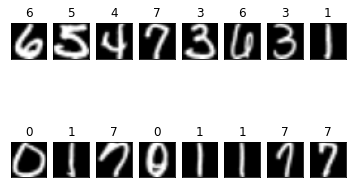

In [7]:
usps = USPSdata()
usps.showSamples(2, 8)

In [8]:
M.prepare_batch(data=usps)
hn_usps = M.train_solver(data=usps, ckpt_name='NaiveNN', prev_scholars=[S1])

▶Naive NN Ep. 1 [####################################] Train [loss :0.071 accuracy:0.975]  Test [loss:0.076 accuracy:0.979]  MNISTdata [loss:0.812 accuracy:0.754]
▶Naive NN Ep. 2 [####################################] Train [loss :0.006 accuracy:1.000]  Test [loss:0.065 accuracy:0.982]  MNISTdata [loss:0.735 accuracy:0.759]
▶Naive NN Ep. 3 [####################################] Train [loss :0.007 accuracy:1.000]  Test [loss:0.073 accuracy:0.982]  MNISTdata [loss:1.258 accuracy:0.684]
▶Naive NN Ep. 4 [####################################] Train [loss :0.004 accuracy:1.000]  Test [loss:0.074 accuracy:0.982]  MNISTdata [loss:1.096 accuracy:0.743]
▶Naive NN Ep. 5 [####################################] Train [loss :0.001 accuracy:1.000]  Test [loss:0.063 accuracy:0.988]  MNISTdata [loss:1.580 accuracy:0.679]


## hello

┕Prepare data input pipeline...
▶Solver Ep. 1 [####################################] Train [loss :0.139 accuracy:0.950]  Test [loss:0.150 accuracy:0.951]  MNISTdata [loss:0.170 accuracy:0.945]
▶Solver Ep. 2 [####################################] Train [loss :0.055 accuracy:0.990]  Test [loss:0.148 accuracy:0.954]  MNISTdata [loss:0.258 accuracy:0.919]
▶Solver Ep. 3 [####################################] Train [loss :0.022 accuracy:0.990]  Test [loss:0.163 accuracy:0.955]  MNISTdata [loss:0.243 accuracy:0.933]
▶Solver Ep. 4 [####################################] Train [loss :0.003 accuracy:1.000]  Test [loss:0.162 accuracy:0.962]  MNISTdata [loss:0.313 accuracy:0.921]
▶Solver Ep. 5 [####################################] Train [loss :0.044 accuracy:0.995]  Test [loss:0.186 accuracy:0.963]  MNISTdata [loss:0.312 accuracy:0.933]
▶Generator  Ep. 1 [####################################] Generator [loss:0.755]  Discriminator [loss:2.101 accuracy:0.120]
▶Generator  Ep. 2 [#####################

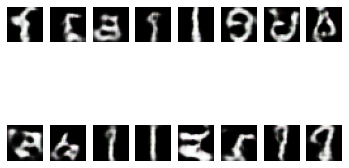

In [9]:
S2 = Scholar()
hs_usps = S2.train_solver(data=usps, ckpt_name='scholar2', prev_scholars=[S1])
S2.train_generator(data=usps, ckpt_name='scholar2')
S2.generate_images()

## hello

SVHN : Training Set (73257, 28, 28, 3)
SVHN : Test Set (26032, 28, 28, 3)
SVHN : Total Number of Images 99289


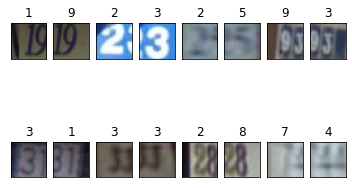

In [10]:
svhn = SVHNdata()
svhn.showSamples(2, 8)

In [11]:
M.prepare_batch(data=svhn)
hn_svhn = M.train_solver(data=svhn, ckpt_name='NaiveNN', prev_scholars=[S1, S2])

▶Naive NN Ep. 1 [####################################] Train [loss :0.797 accuracy:0.780]  Test [loss:0.746 accuracy:0.785]  MNISTdata [loss:2.121 accuracy:0.660]  USPSdata [loss:2.473 accuracy:0.650]
▶Naive NN Ep. 2 [####################################] Train [loss :0.503 accuracy:0.855]  Test [loss:0.644 accuracy:0.809]  MNISTdata [loss:2.580 accuracy:0.634]  USPSdata [loss:2.725 accuracy:0.663]
▶Naive NN Ep. 3 [####################################] Train [loss :0.538 accuracy:0.825]  Test [loss:0.571 accuracy:0.826]  MNISTdata [loss:2.704 accuracy:0.646]  USPSdata [loss:3.003 accuracy:0.642]
▶Naive NN Ep. 4 [####################################] Train [loss :0.647 accuracy:0.835]  Test [loss:0.612 accuracy:0.834]  MNISTdata [loss:3.176 accuracy:0.636]  USPSdata [loss:3.130 accuracy:0.657]
▶Naive NN Ep. 5 [####################################] Train [loss :0.457 accuracy:0.855]  Test [loss:0.552 accuracy:0.851]  MNISTdata [loss:3.298 accuracy:0.628]  USPSdata [loss:3.605 accuracy:0.

## hello

In [12]:
S3 = Scholar()
hs_svhn = S3.train_solver(data=svhn, ckpt_name='scholar3', prev_scholars=[S1, S2])

┕Prepare data input pipeline...
▶Solver Ep. 1 [####################################] Train [loss :0.862 accuracy:0.745]  Test [loss:0.939 accuracy:0.737]  MNISTdata [loss:0.612 accuracy:0.869]  USPSdata [loss:0.437 accuracy:0.904]
▶Solver Ep. 2 [####################################] Train [loss :0.679 accuracy:0.750]  Test [loss:0.781 accuracy:0.780]  MNISTdata [loss:0.636 accuracy:0.866]  USPSdata [loss:0.531 accuracy:0.893]
▶Solver Ep. 3 [####################################] Train [loss :0.598 accuracy:0.805]  Test [loss:0.729 accuracy:0.808]  MNISTdata [loss:0.678 accuracy:0.867]  USPSdata [loss:0.552 accuracy:0.891]
▶Solver Ep. 4 [####################################] Train [loss :0.537 accuracy:0.850]  Test [loss:0.677 accuracy:0.812]  MNISTdata [loss:0.849 accuracy:0.847]  USPSdata [loss:0.751 accuracy:0.876]
▶Solver Ep. 5 [####################################] Train [loss :0.644 accuracy:0.770]  Test [loss:0.682 accuracy:0.818]  MNISTdata [loss:0.813 accuracy:0.862]  USPSdata [

## hello

/home/jwyang/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:530: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/jwyang/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:531: UserWarning: FixedFormatter should only be used together with FixedLocator


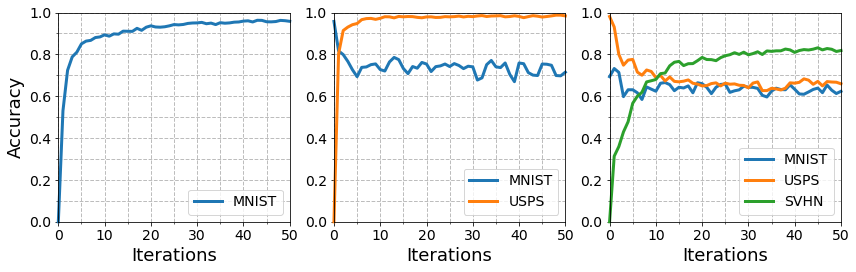

In [13]:
visualize_acc([hn_mnist, hn_usps, hn_svhn])

/home/jwyang/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:530: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/jwyang/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:531: UserWarning: FixedFormatter should only be used together with FixedLocator


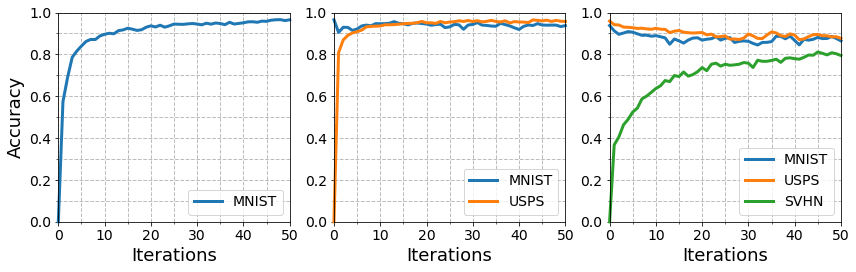

In [14]:
visualize_acc([hs_mnist, hs_usps, hs_svhn])